In [52]:
import pandas as pd
import numpy as np

#### Reading the datasets that were created in the "1-Exploratory Data&Target Analysis" notebook.

In [53]:
household_df = pd.read_csv("datasets/df_household.csv")
individual_df = pd.read_csv("datasets/df_individual.csv")

In [54]:
# Combining the datasets
combined_df = household_df.merge(individual_df, on='hid', how='left')

In [55]:
combined_df.head()

,hid,geo1,geo2,ea,urbrur,hhsize,statocc,rooms,bedrooms,floor,...,disability,blind,deaf,mental,ch_weight,ch_height,children_born,children_surv,births_12m,hhweight_y
0,00a191396a2,1,11,11066,2,1,1,1,1,2,...,0.0,0.0,0.0,0.0,11.93321,86.185972,2.293728,3.114712,0.047968,322.972201
1,0111c7fa67c,1,11,11066,2,1,2,1,0,2,...,0.0,0.0,0.0,0.0,11.93321,86.185972,1.000000,1.000000,0.000000,322.972201
2,01410d9c60d,1,11,11087,2,2,1,4,1,2,...,0.0,0.0,0.0,0.0,11.93321,86.185972,2.293728,3.114712,0.047968,256.192235
3,01410d9c60d,1,11,11087,2,2,1,4,1,2,...,0.0,0.0,0.0,0.0,11.93321,86.185972,2.293728,3.114712,0.047968,256.192235
4,015ff82b55c,1,11,11094,2,2,1,1,1,2,...,0.0,0.0,0.0,0.0,11.93321,86.185972,2.293728,3.114712,0.047968,268.334047


### Feature Engineering

The housing density is calculated by dividing the household size ('hhsize') by the total number of rooms ('rooms') plus bedrooms ('bedrooms'). Representing the number of people per room/bedroom.

In [56]:
# Housing Density
housing_density = combined_df['hhsize'] / (combined_df['rooms'] + combined_df['bedrooms'])

Child & Elder Dependency Ratio is calculated. Initially, we count the number of children (aged under 18) and elderly individuals (aged over 65) per house ('hid'). Then, we merge these counts back into the main dataframe. Finally, the dependency ratio is calculated by dividing the sum of children and elderly by the household size minus the number of dependents. The purpose when calculating the Child & Elder Dependency Ratios is to understand the burden placed on a house by those who are dependent due to age.

In [57]:
# Child & Elder Dependency Ratio
children_elderly_counts = combined_df.groupby('hid').agg(
    num_children=('age', lambda x: (x < 18).sum()),
    num_elderly=('age', lambda x: (x > 65).sum())
).reset_index()

combined_df = combined_df.drop(columns=['num_children', 'num_elderly'], errors='ignore')
combined_df = combined_df.merge(children_elderly_counts, on='hid', how='left')

dependency_ratio = (combined_df['num_children'] + combined_df['num_elderly']) / (combined_df['hhsize'] - combined_df['num_children'] - combined_df['num_elderly']).replace(0, 1)

The employment ratio within households is calculated. We count the number of individuals in the 'labor_force' column with a value of 1 (indicating employment) for each house, then divide this count by the household size ('hhsize') to determine the ratio of employed individuals within each house. The aim is to understand the proportion of employed individuals within houses.

In [58]:
# Employment Ratio
employment_rate = combined_df.groupby('hid')['labor_force'].transform(lambda x: (x == 1).sum()) / combined_df['hhsize']

This code creates a house quality score by assigning points based on materials used for floors, walls, and roofs in houses, then summing those points. The purpose is to numerically assess and compare the overall quality of houses based on these construction material choices.

In [59]:
# House Quality
"""This categorical features more likely to be ordinal. So, we can assign scores to each category. """
def score_floor(material):
    scores = {1: 1, 2: 3, 3: 4, 4: 4, 5: 2, 6: 2}
    return scores.get(material, 0)
"""Floor Material (floor):
        Earth (1): 1 point
        Cement/Concrete (2): 3 points
        Tile (3): 4 points
        Stone (4): 4 points
        Wood (5): 2 points
        Other (6): 2 points"""

def score_walls(material):
    scores = {1: 1, 2: 2, 3: 4, 4: 5, 5: 3, 6: 4, 7: 3, 8: 2}
    return scores.get(material, 0)
"""Wall Material (walls):
        Cardboard/Scrap (1): 1 point
        Wood/Straw (2): 2 points
        Bricks (3): 4 points
        Concrete/Cement (4): 5 points
        Adobe/Mud (5): 3 points
        Stone (6): 4 points
        Metal (7): 3 points
        Other (8): 2 points"""

def score_roof(material):
    scores = {1: 5, 2: 4, 3: 3, 4: 5, 5: 4, 6: 2, 7: 1, 8: 1, 9: 2}
    return scores.get(material, 0)
"""Roof Material (roof):
        Concrete/Cement (1): 5 points
        Tile (2): 4 points
        Asphalt/Laminate (3): 3 points
        Slate (4): 5 points
        Metal (5): 4 points
        Wood (6): 2 points
        Thatch (7): 1 point
        Scrap (8): 1 point
        Other (9): 2 points"""

combined_df['floor_score'] = combined_df['floor'].apply(score_floor)
combined_df['walls_score'] = combined_df['walls'].apply(score_walls)
combined_df['roof_score'] = combined_df['roof'].apply(score_roof)

house_quality_score = combined_df['floor_score'] + combined_df['walls_score'] + combined_df['roof_score']

combined_df = combined_df.drop(columns=['floor', 'walls', 'roof'], errors='ignore')

This code calculates a House Modernity Score by assigning points based on the type of water source, toilet facility, access to electricity, and cooking fuel used in houses. It then sums these points to evaluate and compare the level of modernity within different houses based on these criteria. We aim to provide an overall numerical representation of household modernity.

In [60]:
# House Modernity Score
"""This categorical features more likely to be ordinal. So, we can assign scores to each category. """
def score_water_source(source):
    scores = {11: 7, 12: 6, 13: 4, 14: 2, 21: 2, 31: 3, 32: 2, 41: 3, 42: 2, 43: 3, 51: 1, 61: 1, 62: 0, 71: 0, 96: 1}
    return scores.get(source, 0)
"""Drinking Water Source (water):
        Piped into dwelling (11): 7 points
        Piped to yard/plot (12): 6 points
        Piped to neighbor (13): 4 points
        Public tap/standpipe (14): 2 points
        Tube well or borehole (21): 2 points
        Protected well (31): 3 points
        Unprotected well (32): 2 point
        Protected spring (41): 3 point
        Unprotected spring (42): 2 point
        Rainwater collection (43): 3 point
        Cart with small tank/drum (51): 1 point
        Tanker truck (61): 1 point
        Surface water (62): 0 point
        Bottled water (71): 0 point
        Other sources (96): 1 point"""

def score_piped_water(toilet):
    scores = {0: 0, 1: 3, 2: 4, 3: 5}
    return scores.get(toilet, 0)
"""Water Supply (piped_water):
    No piped water (0): 0 points
    Piped into dwelling (1): 3 points 
    Piped outside the dwelling (2): 4 points 
    Public piped water (3): 5 points"""

def score_toilet(toilet):
    scores = {11: 7, 12: 6, 13: 4, 14: 3, 21: 3, 22: 2, 23: 1, 31: 0, 96: 1}
    return scores.get(toilet, 0)
"""Toilet Facility (toilet):
        Flush to piped sewer system (11): 7 points
        Flush to septic tank (12): 6 points
        Flush to pit latrine (13): 4 points
        Flush to somewhere else (14): 3 points
        Ventilated improved pit latrine (VIP) (21): 3 points
        Pit latrine with slab (22): 2 points
        Pit latrine without slab/open pit (23): 1 points
        No facility/bush/field (31): 0 points
        Other types (96): 1 point"""

def score_toilet_avability(toilet):
    scores = {0: 0, 1: 7, 2: 3}
    return scores.get(toilet, 0)
""" Toilet Facility (flush_toilet):
        No toilet (0): 0 points
        Flush toilet (1): 7 points
        Toilet/latrine with no flush (2): 3 points"""

def score_electricity(electricity):
    scores = {1: 5, 2: 0}
    return scores.get(electricity, 0)
"""Electricity (electricity):
        Yes (1): 5 points
        No (0): 0 points"""

def score_cooking(cooking):
    scores = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1, 6: 1}
    return scores.get(cooking, 0)
"""Cooking Fuel (cook_fuel):
        Electricity (1): 5 points
        Gas (2): 4 points
        Petroleum (3): 3 points
        Wood (4): 2 points
        Coal/charcoal (5): 1 point
        Other (6): 1 point"""

combined_df['water_score'] = combined_df['water'].apply(score_water_source)
combined_df['piped_water_score'] = combined_df['piped_water'].apply(score_piped_water)
combined_df['toilet_score'] = combined_df['toilet'].apply(score_toilet)
combined_df['flush_toilet_score'] = combined_df['flush_toilet'].apply(score_toilet_avability)
combined_df['electricity_score'] = combined_df['electricity'].apply(score_electricity)
combined_df['cooking_score'] = combined_df['cook_fuel'].apply(score_cooking)

house_modernity_score = combined_df['water_score'] + combined_df['toilet_score'] + combined_df['electricity_score'] + combined_df['cooking_score'] + combined_df['piped_water_score'] + combined_df['flush_toilet_score']

combined_df = combined_df.drop(columns=['water', 'piped_water', 'toilet', 'flush_toilet', 'electricity', 'cook_fuel'], errors='ignore')
combined_df = combined_df.drop(columns=['water_score', 'piped_water_score', 'toilet_score', 'flush_toilet_score', 'electricity_score', 'cooking_score'], errors='ignore')

The modernity level of households is determined by assigning scores to owned items like phones, cars, bicycles, electronics, and banking access. The purpose is to create a numeric representation that reflects the modernity of a household's lifestyle based on possession of these items.

In [61]:
# Life Style Modernity Score
lifestyle_score = ( combined_df['phone'] * 1 +
                    combined_df['cell'] * 2 +
                    combined_df['car'] * 5 +
                    combined_df['bicycle'] * 1 +
                    combined_df['motorcycle'] * 3 +
                    combined_df['refrigerator'] * 3 +
                    combined_df['tv'] * 2 +
                    combined_df['radio'] * 1 +
                    combined_df['bank'] * 3) 
"""Scores are based on the items owned"""

'Scores are based on the items owned'

The Education Level computation derives a numeric index by evaluating a household member's school attendance, educational attainment, and literacy. This index aims to provide a measure reflecting the education level of individuals within the household based on these factors.

In [62]:
# Education Level
"""This categorical features more likely to be ordinal. So, we can assign scores to each category. """
def calculate_education_index(row):
    school_attend_score = {1: 2, 2: 0, 3: 1, 4: 0}.get(row['school_attend'], 0)
    educ_attain_score = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}.get(row['educ_attain'], 0)
    literacy_score = {1: 5, 2: 0}.get(row['literacy'], 0)
    
    return school_attend_score + educ_attain_score + literacy_score

education_lvl = combined_df.apply(calculate_education_index, axis=1)

combined_df = combined_df.drop(columns=['school_attend', 'educ_attain'], errors='ignore')

Below, we compute the Child Mortality Rate by subtracting the number of surviving children from the total number of children born in households and then normalizing it to avoid division by zero. This rate helps assess the proportion of children who haven't survived, offering insights into child health and mortality.

In [63]:
# Calculate Child Mortality Rate
CMR = (combined_df['children_born'] - combined_df['children_surv']) / combined_df['children_born'].replace(0, 1)

This feature is a Stability Index based on migration status and adjustments for births and deaths in the last year. It's designed to quantify the stability of households in reference to their migration patterns.

In [64]:
# Stability According to last year
def calculate_stability_index(row):
    
    migration_scores = {0: 0, 10: 1.5, 11: 1, 12: 2, 20: 3, 30: 4, 99: 2}
    migration_score = migration_scores.get(row['migrate_recent'], 0)

    births_deaths_adjustment = - (row['births_12m'] + row['deaths_12m'])

    return max(migration_score + births_deaths_adjustment, 0)

stability_index = combined_df.apply(calculate_stability_index, axis=1)

We determine the Polygamy Status by counting the number of spouses per house and categorizing households as polygamous if they have more than one spouse present. The purpose is to identify households practicing polygamy.

In [65]:
# Polygamy Status
spouse_count = combined_df[combined_df['relation'] == 2].groupby('hid').size().reset_index(name='spouse_count')

combined_df = combined_df.merge(spouse_count, on='hid', how='left')

combined_df['spouse_count'].fillna(0, inplace=True)

polygamous = combined_df['spouse_count'] > 1

Average Age per household is calculated by finding the mean age of individuals within each household. This provides a single representative age value for each household.

In [66]:
# Average Age
avg_age_per_household = combined_df.groupby('hid')['age'].mean().reset_index(name='average_age')

combined_df = combined_df.merge(avg_age_per_household, on='hid', how='left')

This code computes the Disability Member Count by summing the occurrences of disabilities among individuals within households. 

In [67]:
# Disabilty Member Count
disability_columns = ['blind', 'deaf', 'mental']
disability_member_count = combined_df[disability_columns].sum(axis=1)

The Women's Empowerment Score is computed to see the level of empowerment within households. It assesses empowerment by considering the presence of female heads of households and the count of employed females, expressing this as a ratio relative to the total number of female household members. 

In [68]:
# Women's Empowerment Score
combined_df['is_female_head'] = ((combined_df['relation'] == 1) & (combined_df['sex'] == 2)).astype(int)

combined_df['employed_females'] = ((combined_df['sex'] == 2) & (combined_df['act_status'] == 1)).astype(int)
employed_females_count = combined_df.groupby('hid')['employed_females'].sum().reset_index(name='employed_females_count')

female_count = combined_df[combined_df['sex'] == 2].groupby('hid').size().reset_index(name='female_count')

combined_df = combined_df.merge(employed_females_count, on='hid', how='left')
combined_df = combined_df.merge(female_count, on='hid', how='left')

combined_df['employed_females_count'].fillna(0, inplace=True)
combined_df['female_count'].fillna(0, inplace=True)

womens_empowerment_score = (combined_df['is_female_head'] + combined_df['employed_females_count']) / combined_df['female_count'].replace(0, 1)

This code calculates the Child Development Index by computing the Body Mass Index for children. It involves converting the height from centimeters to meters and then computing BMI using the weight and adjusted height. This is an indicator of child health and development.

In [69]:
# Child Development Index
combined_df['ch_height_m'] = combined_df['ch_height'] / 100  # Convert cm to meters

child_bmi = combined_df['ch_weight'] / (combined_df['ch_height_m'] ** 2)

In [70]:
# Aggregating the data
aggregated_data = pd.DataFrame({
    'housing_density': housing_density,
    'dependency_ratio': dependency_ratio,
    'employment_rate': employment_rate,
    'house_quality_score': house_quality_score,
    'house_modernity_score': house_modernity_score,
    'lifestyle_score': lifestyle_score,
    'education_lvl': education_lvl,
    'child_mortality_rate': CMR,
    'stability_index': stability_index,
    'polygamous': polygamous,
    'disability_member_count': disability_member_count,
    'womens_empowerment_score': womens_empowerment_score,
    'child_bmi': child_bmi
})

In [71]:
combined_df = pd.concat([combined_df, aggregated_data], axis=1)

The code calculates the Living Conditions Level Score by combining various factors related to employment rate, house quality, modernity, and lifestyle. It divides this combination by a ratio involving dependency, housing density, aiming to create a score reflecting the overall living conditions within households.

In [72]:
# Living Conditions Level
living_conditions_level_score = (((combined_df['employment_rate']*10 +  
                        combined_df['house_quality_score'] +  
                        combined_df['house_modernity_score'] +  
                        combined_df['lifestyle_score'])/ (combined_df['dependency_ratio'] + combined_df['housing_density'])))


This code categorizes child health based on BMI percentile data according to the child's age and sex. It uses specific BMI percentile values to classify the child's health status into categories like Very Underweight, Underweight, Healthy Weight, Overweight, or Obese.

In [73]:
# Child Health Index
percentile_data = {
    ('Girl', 1): {'5th': 12, '15th': 13.2, '85th': 16, '95th': 17.5},
    ('Girl', 2): {'5th': 13, '15th': 14.2, '85th': 17.2, '95th': 19},
    ('Girl', 3): {'5th': 13.6, '15th': 14.8, '85th': 17.8, '95th': 19.6},
    ('Girl', 4): {'5th': 13.8, '15th': 15.2, '85th': 18.2, '95th': 20},
    ('Girl', 5): {'5th': 14, '15th': 15.4, '85th': 18.4, '95th': 20.2},
    ('Girl', 6): {'5th': 14.2, '15th': 15.6, '85th': 18.6, '95th': 20.3},
    ('Girl', 7): {'5th': 14.2, '15th': 15.6, '85th': 18.6, '95th': 20.3},
    ('Girl', 8): {'5th': 14.1, '15th': 15.4, '85th': 18.5, '95th': 20.2},
    ('Girl', 9): {'5th': 14, '15th': 15.2, '85th': 18.4, '95th': 20.1},
    ('Girl', 10): {'5th': 14, '15th': 15.2, '85th': 18.2, '95th': 19.9},
    ('Girl', 11): {'5th': 13.8, '15th': 15.1, '85th': 18, '95th': 19.8},
    ('Girl', 12): {'5th': 13.8, '15th': 15, '85th': 17.8, '95th': 19.6},
    ('Girl', 13): {'5th': 13.7, '15th': 14.9, '85th': 17.7, '95th': 19.4},
    ('Girl', 14): {'5th': 13.6, '15th': 14.8, '85th': 17.6, '95th': 19.3},
    ('Girl', 15): {'5th': 13.5, '15th': 14.7, '85th': 17.5, '95th': 19.2},
    ('Girl', 16): {'5th': 13.5, '15th': 14.6, '85th': 17.4, '95th': 19.1},
    ('Girl', 17): {'5th': 13.4, '15th': 14.5, '85th': 17.3, '95th': 19},
    ('Girl', 18): {'5th': 13.4, '15th': 14.4, '85th': 17.2, '95th': 18.9},
    ('Girl', 19): {'5th': 13.3, '15th': 14.4, '85th': 17.1, '95th': 18.8},
    ('Girl', 20): {'5th': 13.2, '15th': 14.3, '85th': 17, '95th': 18.7},
    ('Girl', 21): {'5th': 13.2, '15th': 14.25, '85th': 17, '95th': 18.6},
    ('Girl', 22): {'5th': 13.15, '15th': 14.2, '85th': 16.9, '95th': 18.55},
    ('Girl', 23): {'5th': 13.1, '15th': 14.2, '85th': 16.8, '95th': 18.5},
    ('Girl', 24): {'5th': 13.1, '15th': 14.2, '85th': 16.8, '95th': 18.4},
    ('Girl', 25): {'5th': 13, '15th': 14.1, '85th': 16.8, '95th': 18.4},
    ('Girl', 26): {'5th': 13, '15th': 14, '85th': 16.9, '95th': 18.5},
    ('Girl', 27): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 28): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 29): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 30): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 31): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 32): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 33): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 34): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 35): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 36): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 37): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 38): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 39): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 40): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 41): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 42): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 43): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 44): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 45): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 46): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 47): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 48): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 49): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 50): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 51): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 52): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 53): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 54): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 55): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 56): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 57): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 58): {'5th': 13, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 59): {'5th': 12.9, '15th': 14, '85th': 17, '95th': 18.5},
    ('Girl', 60): {'5th': 12.8, '15th': 14, '85th': 17, '95th': 18.6},
    
    ('Boy', 1): {'5th': 12.4, '15th': 13.6, '85th': 16.4, '95th': 17.8},
    ('Boy', 2): {'5th': 13.8, '15th': 15, '85th': 17.8, '95th': 19.4},
    ('Boy', 3): {'5th': 14.2, '15th': 15.5, '85th': 18.2, '95th': 20},
    ('Boy', 4): {'5th': 14.4, '15th': 15.8, '85th': 18.6, '95th': 20.3},
    ('Boy', 5): {'5th': 14.6, '15th': 15.95, '85th': 18.8, '95th': 20.4},
    ('Boy', 6): {'5th': 14.8, '15th': 16, '85th': 18.8, '95th': 20.45},
    ('Boy', 7): {'5th': 14.8, '15th': 16, '85th': 18.8, '95th': 20.45},
    ('Boy', 8): {'5th': 14.7, '15th': 15.9, '85th': 18.8, '95th': 20.4},
    ('Boy', 9): {'5th': 14.6, '15th': 15.8, '85th': 18.6, '95th': 20.3},
    ('Boy', 10): {'5th': 14.6, '15th': 15.8, '85th': 18.5, '95th': 20.2},
    ('Boy', 11): {'5th': 14.5, '15th': 15.6, '85th': 18.4, '95th': 20},
    ('Boy', 12): {'5th': 14.4, '15th': 15.5, '85th': 18.2, '95th': 19.8},
    ('Boy', 13): {'5th': 14.3, '15th': 15.4, '85th': 18.1, '95th': 19.75},
    ('Boy', 14): {'5th': 14.2, '15th': 15.3, '85th': 18, '95th': 19.65},
    ('Boy', 15): {'5th': 14.1, '15th': 15.2, '85th': 17.8, '95th': 19.4},
    ('Boy', 16): {'5th': 14, '15th': 15.1, '85th': 17.7, '95th': 19.3},
    ('Boy', 17): {'5th': 14, '15th': 15, '85th': 17.6, '95th': 19.2},
    ('Boy', 18): {'5th': 13.85, '15th': 14.95, '85th': 17.5, '95th': 19},
    ('Boy', 19): {'5th': 13.8, '15th': 14.85, '85th': 17.4, '95th': 18.9},
    ('Boy', 20): {'5th': 13.75, '15th': 14.8, '85th': 17.3, '95th': 18.8},
    ('Boy', 21): {'5th': 13.7, '15th': 14.75, '85th': 17.2, '95th': 18.8},
    ('Boy', 22): {'5th': 13.6, '15th': 14.65, '85th': 17.2, '95th': 18.7},
    ('Boy', 23): {'5th': 13.6, '15th': 14.6, '85th': 17.1, '95th': 18.6},
    ('Boy', 24): {'5th': 13.6, '15th': 14.6, '85th': 17, '95th': 18.5},
    ('Boy', 25): {'5th': 13.4, '15th': 14.5, '85th': 16.95, '95th': 18.45},
    ('Boy', 26): {'5th': 13.4, '15th': 14.5, '85th': 16.95, '95th': 18.45},
    ('Boy', 27): {'5th': 13.4, '15th': 14.5, '85th': 16.95, '95th': 18.45},
    ('Boy', 28): {'5th': 13.4, '15th': 14.5, '85th': 16.95, '95th': 18.45},
    ('Boy', 29): {'5th': 13.4, '15th': 14.5, '85th': 16.95, '95th': 18.45},
    ('Boy', 30): {'5th': 13.4, '15th': 14.5, '85th': 16.95, '95th': 18.45},
    ('Boy', 31): {'5th': 13.2, '15th': 14.4, '85th': 16.9, '95th': 18.4},
    ('Boy', 32): {'5th': 13.2, '15th': 14.4, '85th': 16.9, '95th': 18.4},
    ('Boy', 33): {'5th': 13.2, '15th': 14.4, '85th': 16.9, '95th': 18.4},
    ('Boy', 34): {'5th': 13.2, '15th': 14.4, '85th': 16.9, '95th': 18.4},
    ('Boy', 35): {'5th': 13.2, '15th': 14.4, '85th': 16.9, '95th': 18.4},
    ('Boy', 36): {'5th': 13.2, '15th': 14.4, '85th': 16.9, '95th': 18.4},
    ('Boy', 37): {'5th': 13.1, '15th': 14.3, '85th': 16.8, '95th': 18.35},
    ('Boy', 38): {'5th': 13.1, '15th': 14.3, '85th': 16.8, '95th': 18.35},
    ('Boy', 39): {'5th': 13.1, '15th': 14.3, '85th': 16.8, '95th': 18.35},
    ('Boy', 40): {'5th': 13.1, '15th': 14.3, '85th': 16.8, '95th': 18.35},
    ('Boy', 41): {'5th': 13.1, '15th': 14.3, '85th': 16.8, '95th': 18.35},
    ('Boy', 42): {'5th': 13.1, '15th': 14.3, '85th': 16.8, '95th': 18.35},
    ('Boy', 43): {'5th': 13, '15th': 14.2, '85th': 16.75, '95th': 18.3},
    ('Boy', 44): {'5th': 13, '15th': 14.2, '85th': 16.75, '95th': 18.3},
    ('Boy', 45): {'5th': 13, '15th': 14.2, '85th': 16.75, '95th': 18.3},
    ('Boy', 46): {'5th': 13, '15th': 14.2, '85th': 16.75, '95th': 18.3},
    ('Boy', 47): {'5th': 13, '15th': 14.2, '85th': 16.75, '95th': 18.3},
    ('Boy', 48): {'5th': 13, '15th': 14.2, '85th': 16.75, '95th': 18.3},
    ('Boy', 49): {'5th': 12.8, '15th': 14.1, '85th': 16.7, '95th': 18.3},
    ('Boy', 50): {'5th': 12.8, '15th': 14.1, '85th': 16.7, '95th': 18.3},
    ('Boy', 51): {'5th': 12.8, '15th': 14.1, '85th': 16.7, '95th': 18.3},
    ('Boy', 52): {'5th': 12.8, '15th': 14.1, '85th': 16.7, '95th': 18.3},
    ('Boy', 53): {'5th': 12.8, '15th': 14.1, '85th': 16.7, '95th': 18.3},
    ('Boy', 54): {'5th': 12.8, '15th': 14.1, '85th': 16.7, '95th': 18.3},
    ('Boy', 55): {'5th': 12.8, '15th': 14, '85th': 16.6, '95th': 18.25},
    ('Boy', 56): {'5th': 12.8, '15th': 14, '85th': 16.6, '95th': 18.25},
    ('Boy', 57): {'5th': 12.8, '15th': 14, '85th': 16.6, '95th': 18.25},
    ('Boy', 58): {'5th': 12.8, '15th': 14, '85th': 16.6, '95th': 18.25},
    ('Boy', 59): {'5th': 12.8, '15th': 14, '85th': 16.6, '95th': 18.25},
    ('Boy', 60): {'5th': 12.8, '15th': 14, '85th': 16.6, '95th': 18.25},
}

def categorize_health(bmi, age_months, sex, percentile_data):

    sex_str = 'Boy' if sex == 1 else 'Girl'
    
    if pd.isna(age_months) or age_months not in range(1, 61):
        return 'Data Not Available'
    
    percentiles = percentile_data[(sex_str, age_months)]

    if bmi < percentiles['5th']:
        return 'Very Underweight'
    elif bmi < percentiles['15th']:
        return 'Underweight'
    elif bmi < percentiles['85th']:
        return 'Healthy Weight'
    elif bmi < percentiles['95th']:
        return 'Overweight'
    else:
        return 'Obese'

health_category = combined_df.apply(lambda row: categorize_health(row['child_bmi'], row['age_month'], row['sex'], percentile_data), axis=1)


In [74]:
# Aggregating the data
aggregated_data = pd.DataFrame({
    'living_conditions_level_score': living_conditions_level_score,
    'health_category': health_category
})

In [75]:
combined_df = pd.concat([combined_df, aggregated_data], axis=1)

In [76]:
combined_df.head(10)

,hid,geo1,geo2,ea,urbrur,hhsize,statocc,rooms,bedrooms,phone,...,lifestyle_score,education_lvl,child_mortality_rate,stability_index,polygamous,disability_member_count,womens_empowerment_score,child_bmi,living_conditions_level_score,health_category
0,00a191396a2,1,11,11066,2,1,1,1,1,0,...,5,10,-0.357925,0.000000,False,0.0,0.0,16.065126,84.000000,Data Not Available
1,0111c7fa67c,1,11,11066,2,1,2,1,0,0,...,5,6,0.000000,3.000000,False,0.0,1.0,16.065126,39.000000,Data Not Available
2,01410d9c60d,1,11,11087,2,2,1,4,1,0,...,11,10,-0.357925,0.952032,False,0.0,0.0,16.065126,155.000000,Data Not Available
3,01410d9c60d,1,11,11087,2,2,1,4,1,0,...,11,6,-0.357925,0.952032,False,0.0,0.0,16.065126,155.000000,Data Not Available
4,015ff82b55c,1,11,11094,2,2,1,1,1,0,...,10,6,-0.357925,1.952032,False,0.0,1.0,16.065126,56.000000,Data Not Available
5,015ff82b55c,1,11,11094,2,2,1,1,1,0,...,10,6,0.000000,4.000000,False,0.0,1.0,16.065126,56.000000,Data Not Available
6,01c39d3df0d,1,11,11094,2,1,2,3,2,1,...,16,10,-0.357925,2.952032,False,0.0,0.0,16.065126,290.000000,Data Not Available
7,027fe2e901f,1,11,11003,2,2,1,3,2,1,...,7,6,0.076923,0.000000,False,0.0,1.0,16.065126,21.666667,Data Not Available
8,027fe2e901f,1,11,11003,2,2,1,3,2,1,...,7,6,-0.357925,1.952032,False,1.0,0.0,16.065126,21.666667,Data Not Available
9,02afa0073ff,1,11,11024,2,3,2,4,2,0,...,13,11,-0.357925,2.952032,False,0.0,0.5,16.065126,64.666667,Data Not Available


<Axes: xlabel='urbrur'>

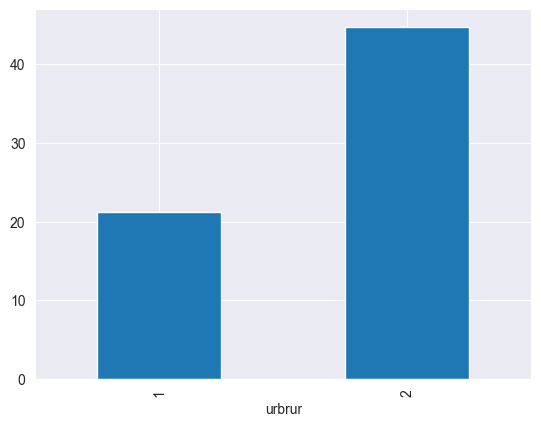

In [77]:
# Urban/Rural vs Living Conditions Level
combined_df.groupby('urbrur')['living_conditions_level_score'].mean()
combined_df.groupby('urbrur')['living_conditions_level_score'].mean().plot(kind='bar')


<Axes: xlabel='education_lvl'>

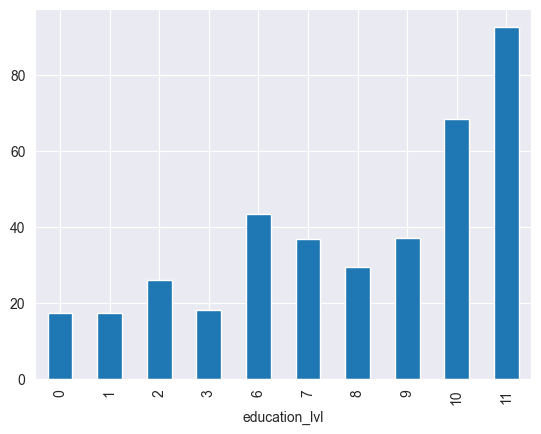

In [78]:
# Education Level vs Living Conditions Level
combined_df.groupby('education_lvl')['living_conditions_level_score'].mean()
combined_df.groupby('education_lvl')['living_conditions_level_score'].mean().plot(kind='bar')

<Axes: xlabel='urbrur'>

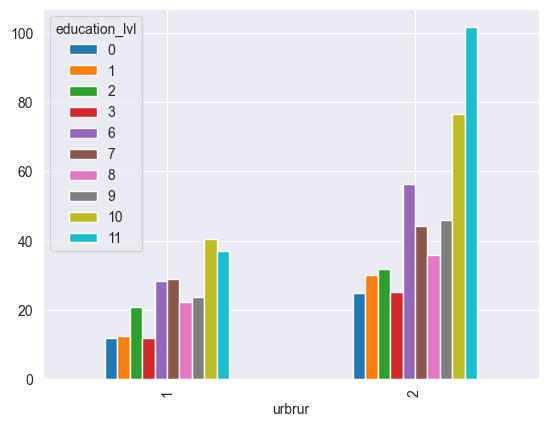

In [79]:
# Print living conditions level scores via ubrur and education level
combined_df.groupby(['urbrur', 'education_lvl'])['living_conditions_level_score'].mean()

# plot the data
combined_df.groupby(['urbrur', 'education_lvl'])['living_conditions_level_score'].mean().unstack().plot(kind='bar')


In [80]:
# All Columns
expented_df = combined_df

column_list = list(expented_df.columns)
column_list

['hid',
 'geo1',
 'geo2',
 'ea',
 'urbrur',
 'hhsize',
 'statocc',
 'rooms',
 'bedrooms',
 'phone',
 'cell',
 'car',
 'bicycle',
 'motorcycle',
 'refrigerator',
 'tv',
 'radio',
 'bank',
 'deaths_12m',
 'exp_01',
 'exp_02',
 'exp_03',
 'exp_04',
 'exp_05',
 'exp_06',
 'exp_07',
 'exp_08',
 'exp_09',
 'exp_10',
 'exp_11',
 'exp_12',
 'tot_exp',
 'tot_food',
 'share_food',
 'pc_exp',
 'quint_nat',
 'quint_urb',
 'quint_rur',
 'hhweight_x',
 'popweight',
 'idno',
 'relation',
 'sex',
 'age',
 'age_month',
 'marstat',
 'religion',
 'yrs_school',
 'literacy',
 'act_status',
 'labor_force',
 'occupation',
 'industry',
 'migrate_recent',
 'disability',
 'blind',
 'deaf',
 'mental',
 'ch_weight',
 'ch_height',
 'children_born',
 'children_surv',
 'births_12m',
 'hhweight_y',
 'num_children',
 'num_elderly',
 'floor_score',
 'walls_score',
 'roof_score',
 'spouse_count',
 'average_age',
 'is_female_head',
 'employed_females',
 'employed_females_count',
 'female_count',
 'ch_height_m',
 'housing

#### Convert Data to per Houshold Information

In [81]:
# Maximum Education Level per Household
highest_edu_lvl = expented_df.groupby('hid')['education_lvl'].max().reset_index(name='highest_edu_lvl')

expented_df = expented_df.merge(highest_edu_lvl, on='hid', how='left')

expented_df = expented_df.drop('education_lvl', axis=1)

In [82]:
# Average CMR per Household
avg_cmr = expented_df.groupby('hid')['child_mortality_rate'].mean().reset_index(name='avg_cmr')

expented_df = expented_df.merge(avg_cmr, on='hid', how='left')

expented_df = expented_df.drop('child_mortality_rate', axis=1)

In [83]:
# Stability Index per Household
unstability_index = expented_df.groupby('hid')['stability_index'].sum().reset_index(name='unstability_index')

expented_df = expented_df.merge(unstability_index, on='hid', how='left')

expented_df = expented_df.drop('stability_index', axis=1)

In [84]:
# Maximum Women's Empowerment Score per Household
womens_empowerment_index = expented_df.groupby('hid')['womens_empowerment_score'].max().reset_index(name='womens_empowerment_index')

expented_df = expented_df.merge(womens_empowerment_index, on='hid', how='left')

expented_df = expented_df.drop('womens_empowerment_score', axis=1)

In [85]:
# Sum of Disability Member Count per Household
disability_member_count = expented_df.groupby('hid')['disability_member_count'].sum().reset_index(name='disability_count')

expented_df = expented_df.merge(disability_member_count, on='hid', how='left')

expented_df = expented_df.drop('disability_member_count', axis=1)

In [86]:
# Maximum Religious Diversity per Household
# Count the number of unique religions for each household
unique_religion_counts = combined_df.groupby('hid')['religion'].nunique().reset_index(name='unique_religions')

# Merge the unique religion counts with the main DataFrame
expented_df = expented_df.merge(unique_religion_counts, on='hid', how='left')

# Optionally, if you want to drop the original 'religion' column from expented_df
expented_df = expented_df.drop('religion', axis=1)


In [87]:
# One Hot Encoding for Health Category
health_category_one_hot = pd.get_dummies(expented_df['health_category'], prefix='health')

expented_df = pd.concat([expented_df, health_category_one_hot], axis=1)

health_category_household = expented_df.groupby('hid')[health_category_one_hot.columns].sum().reset_index()

expented_df = expented_df.merge(health_category_household, on='hid', how='left', suffixes=('', '_per_household'))

expented_df = expented_df.drop('health_category', axis=1)
expented_df = expented_df.drop(health_category_one_hot.columns, axis=1)
expented_df = expented_df.drop('child_bmi', axis=1)

In [88]:
# Male & Female Count per Household
expented_df['male_count'] = (expented_df['sex'] == 1).astype(int)
expented_df['female_count'] = (expented_df['sex'] == 2).astype(int)

male_female_counts = expented_df.groupby('hid')[['male_count', 'female_count']].sum().reset_index()

expented_df = expented_df.merge(male_female_counts, on='hid', how='left')

expented_df['num_male'] = expented_df['male_count_y']
expented_df['num_female'] = expented_df['female_count_y']

expented_df = expented_df.drop(['sex', 'male_count_x', 'male_count_y', 'female_count_x', 'female_count_y'], axis=1)

In [89]:
# One Hot Encoding for Martial Status
martial_status_one_hot = pd.get_dummies(expented_df['marstat'], prefix='marstat')

expented_df = pd.concat([expented_df, martial_status_one_hot], axis=1)

martial_status_household = expented_df.groupby('hid')[martial_status_one_hot.columns].sum().reset_index()

expented_df = expented_df.merge(martial_status_household, on='hid', how='left', suffixes=('', '_per_household'))

expented_df = expented_df.drop('marstat', axis=1)
expented_df = expented_df.drop(martial_status_one_hot.columns, axis=1)

In [90]:
# One Hot Encoding for Migration Status
migration_status_one_hot = pd.get_dummies(expented_df['migrate_recent'], prefix='migrate')

expented_df = pd.concat([expented_df, migration_status_one_hot], axis=1)

migration_status_household = expented_df.groupby('hid')[migration_status_one_hot.columns].sum().reset_index()

expented_df = expented_df.merge(migration_status_household, on='hid', how='left', suffixes=('', '_per_household'))

expented_df = expented_df.drop('migrate_recent', axis=1)
expented_df = expented_df.drop(migration_status_one_hot.columns, axis=1)

In [91]:
# One Hot Encoding for Occupation & Industry
occupation_one_hot = pd.get_dummies(expented_df['occupation'], prefix='occupation')
industry_one_hot = pd.get_dummies(expented_df['industry'], prefix='industry')

expented_df = pd.concat([expented_df, occupation_one_hot, industry_one_hot], axis=1)

occupation_household = expented_df.groupby('hid')[occupation_one_hot.columns].sum().reset_index()
industry_household = expented_df.groupby('hid')[industry_one_hot.columns].sum().reset_index()

expented_df = expented_df.merge(occupation_household, on='hid', how='left', suffixes=('', '_per_household'))
expented_df = expented_df.merge(industry_household, on='hid', how='left', suffixes=('', '_per_household'))

expented_df = expented_df.drop('occupation', axis=1)
expented_df = expented_df.drop('industry', axis=1)
expented_df = expented_df.drop(occupation_one_hot.columns, axis=1)
expented_df = expented_df.drop(industry_one_hot.columns, axis=1)

In [92]:
# Percentage of Literate People per Household
literate_df = expented_df[expented_df['literacy'] != 0] # Filter out individuals for whom literacy is not applicable

num_literate = literate_df[literate_df['literacy'] == 1].groupby('hid').size().reset_index(name='num_literate')

total_applicable = literate_df.groupby('hid').size().reset_index(name='total_applicable')

literate_stats = num_literate.merge(total_applicable, on='hid')

literate_stats['percent_literate'] = (literate_stats['num_literate'] / literate_stats['total_applicable']) * 100

expented_df = expented_df.merge(literate_stats[['hid', 'percent_literate']], on='hid', how='left')

expented_df = expented_df.drop('literacy', axis=1)

In [93]:
# Total Number of Children Born per Household
total_children_born_per_household = expented_df.groupby('hid')['children_born'].sum().reset_index(name='total_children_born')

expented_df = expented_df.merge(total_children_born_per_household, on='hid', how='left')

expented_df = expented_df.drop('children_born', axis=1)

In [94]:
# Remove individual columns
columns_to_drop = ['idno', 'relation', 'age', 'age_month', 'yrs_school', 'act_status', 'labor_force', 'disability', 'blind', 'deaf', 'mental', 'ch_weight', 'ch_height', 'children_surv',
                   'births_12m', 'floor_score', 'walls_score', 'roof_score', 'spouse_count', 'is_female_head', 'employed_females', 'employed_females_count',
                   'ch_height_m']

expented_df = expented_df.drop(columns_to_drop, axis=1)

In [95]:
# Drop duplicate rows
expented_df = expented_df.drop_duplicates()

In [96]:
expented_df.head(10)

,hid,geo1,geo2,ea,urbrur,hhsize,statocc,rooms,bedrooms,phone,...,industry_8.0_per_household,industry_9.0_per_household,industry_10.0_per_household,industry_11.0_per_household,industry_12.0_per_household,industry_13.0_per_household,industry_14.0_per_household,industry_15.0_per_household,percent_literate,total_children_born
0,00a191396a2,1,11,11066,2,1,1,1,1,0,...,0,0,0,0,0,0,0,0,100.0,2.293728
1,0111c7fa67c,1,11,11066,2,1,2,1,0,0,...,0,0,0,0,0,0,0,0,100.0,1.000000
2,01410d9c60d,1,11,11087,2,2,1,4,1,0,...,0,0,0,1,0,0,0,0,100.0,4.587456
4,015ff82b55c,1,11,11094,2,2,1,1,1,0,...,0,0,0,0,0,0,0,0,100.0,4.293728
6,01c39d3df0d,1,11,11094,2,1,2,3,2,1,...,0,0,0,0,0,0,0,0,100.0,2.293728
7,027fe2e901f,1,11,11003,2,2,1,3,2,1,...,0,0,0,0,0,0,0,0,100.0,15.293728
9,02afa0073ff,1,11,11024,2,3,2,4,2,0,...,0,0,0,2,0,0,0,0,100.0,5.587456
12,033e22694f2,1,11,11041,2,2,1,3,2,1,...,0,0,0,0,0,0,0,1,100.0,2.293728
14,03a770af9f0,1,11,11066,2,1,2,1,1,0,...,0,0,0,0,0,0,0,0,100.0,2.293728
15,0424d8c9572,1,11,11034,2,4,3,3,2,0,...,0,0,0,0,0,0,0,0,50.0,16.881184


In [97]:
expented_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7996 entries, 0 to 32339
Columns: 107 entries, hid to total_children_born
dtypes: bool(1), float64(19), int32(2), int64(84), object(1)
memory usage: 6.5+ MB


In [98]:
has_duplicates = expented_df['hid'].duplicated().any()
has_duplicates

False

In [99]:
# Remove UrbRur Related Columns
columns_to_drop = ['hid', 'geo1', 'geo2', 'ea', 'quint_urb', 'quint_rur']

expented_df = expented_df.drop(columns_to_drop, axis=1)

#### Once again saving the final data frame locally to use it in the "3-Feature Selection" notebook.

In [100]:
expented_df.to_csv('datasets/generated_household_data.csv', index=False)